In [1]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
import seaborn as sns
from scipy import stats
from tabulate import tabulate
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        path = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        if os.getenv("COMPUTERNAME") == 'PYRRHA':
                path = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        else:
            path = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
        
df = pd.read_csv(get_path() + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')


#### Crop activity data to get rid of activity #3

In [3]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

Functions from the notebook ""

In [4]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

## Overview of analysis
So we want to take a look at what the high prior knowledge are doing. Remember that we have 22 such students, 19 HH and 3 HL. Let's keep the HL and call HH+HL = HH

In [5]:
median_learning0 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning0,row,"z pre"),axis=1)
median_learning2 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning2,row,"z post t2"),axis=1)

In [6]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 19
high low 3
low high 38
low low 36


We want to compare the three groups to each other. We would like to know if:
- HH look like LL in which case LL use experts strategies that are productive with certain level of prior knowledge
- HH look like LH in which case they used productive strategies

We need to make a new funciton to run the sequence mining with 3 groups.

### Let's make those three groups

In [7]:
def label_3_groups (row):
    if row['split pre']  == 'high' and row['split post t2'] == 'high':
        return 'HH'
    if row['split pre']  == 'high' and row['split post t2'] == 'low':
        return 'HL'
    if row['split pre']  == 'low' and row['split post t2'] == 'high':
        return 'LH'
    if row['split pre']  == 'low' and row['split post t2'] == 'low':
        return 'LL'
df_scores['three groups'] = df_scores.apply (lambda row: label_3_groups (row),axis=1)

### Let's run the sequence mining like we usually do on all 3 groups

In [8]:
students = list(set(get_students()) - set(df_scores[df_scores['three groups']=='HL']['student']))
CUT_OFF = 0.3 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 1
longest_seq_length = 10

### PARAMETERS
attribute = 'three groups'
level1 = 'LH'
level2 = 'LL'
level3 = 'HH'
family_category = "Family"
group_sizes = np.array([len(set(df_scores[df_scores['three groups']==level1]['student'])),len(set(df_scores[df_scores['three groups']==level2]['student'])),len(set(df_scores[df_scores['three groups']==level3]['student']))])


BINS = 1
axis = 1
sequence_counts_group = get_sequence_use_by_timebin(df,students,family_category,
                                          BINS,attribute,level1,level2,
                                          shortest_seq_length,longest_seq_length,CUT_OFF,level3='HH',ignore=['I'])
sequence_counts_group = {s:(counts.T/group_sizes).T for s,counts in sequence_counts_group.iteritems()}
tops_group = get_top_seqs(rank_sequences(sequence_counts_group,BINS,axis),15)

BINS = 4
axis = None
sequence_counts_both = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,level3='HH',ignore=['I'])
sequence_counts_both = {s:counts/group_sizes[:,None] for s,counts in sequence_counts_both.iteritems()}
tops_both = get_top_seqs(rank_sequences(sequence_counts_both,BINS,axis),15)

BINS = 4
axis = 0
sequence_counts_time = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,level3='HH',ignore=['I'])
sequence_counts_time = {s:counts/group_sizes[:,None] for s,counts in sequence_counts_time.iteritems()}
tops_time = get_top_seqs(rank_sequences(sequence_counts_time,BINS,axis),15)

Getting sequence use over 1 time bins for 93 students split by three groups. 
    Keeping only sequences used once by at least 30% of students 
    in each group and overall.
Getting sequence use over 4 time bins for 93 students split by three groups. 
    Keeping only sequences used once by at least 30% of students 
    in each group and overall.
Getting sequence use over 4 time bins for 93 students split by three groups. 
    Keeping only sequences used once by at least 30% of students 
    in each group and overall.


In [9]:
table = [['SEQ','IG','LH','LL','HH']]
tops_group.sort(key=lambda x: -x[1])
for seq,ig in tops_group:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    row = [seq,str(round(ig,2))] + [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_group[seq].T)[0])]
    table.append(row)
print tabulate(table)

--------  ----  --  --  --
SEQ       IG    LH  LL  HH
CPCTcCP   0.35  10  30  5
TbPTbC    0.32  7   8   31
TbPCPCP   0.31  5   13  31
PTcPTc    0.26  31  25  5
TcCTs     0.25  21  30  5
PTsPCTs   0.25  31  5   21
CPCTsC    0.22  13  36  10
PTcCTc    0.2   47  33  10
TsCTsC    0.19  15  36  10
TcCPCP    0.18  7   30  26
CTcCTcCP  0.18  7   30  26
PTcCTcP   0.17  31  13  10
PCTcCP    0.16  21  36  10
PCPTs     0.14  26  11  36
TcCPTc    0.13  23  33  10
--------  ----  --  --  --


In [12]:
print sequence_counts_time[seq]

[[ 0.21  0.03  0.05  0.  ]
 [ 0.11  0.    0.06  0.06]
 [ 0.32  0.05  0.05  0.  ]]


In [11]:
table = [['SEQ','IG','LH','LL','HH']]
tops_time.sort(key=lambda x: -x[1])
for seq,ig in tops_time:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_time[seq].T*group_sizes)[0]
    row = [seq,str(round(ig,2))]+ [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_time[seq].T)[0])]
    table.append(row)
print tabulate(table)

-------  ----  --  --  --
SEQ      IG    LH  LL  HH
CPTb     1.41  34  25  31
TbPTb    1.37  18  8   31
TbPTbC   1.29  7   5   31
TbCPC    1.19  34  22  26
CTbCP    1.09  28  22  26
PTbC     1.08  28  25  36
TbCTbP   1.02  18  25  26
TbCP     1.02  36  25  36
PTb      0.97  44  27  52
CTbPCP   0.91  10  8   26
CTbPC    0.75  26  27  47
TbCTb    0.74  31  36  36
PTsPCTs  0.72  23  5   10
CTbP     0.68  34  38  63
TbPCP    0.64  21  11  31
-------  ----  --  --  --


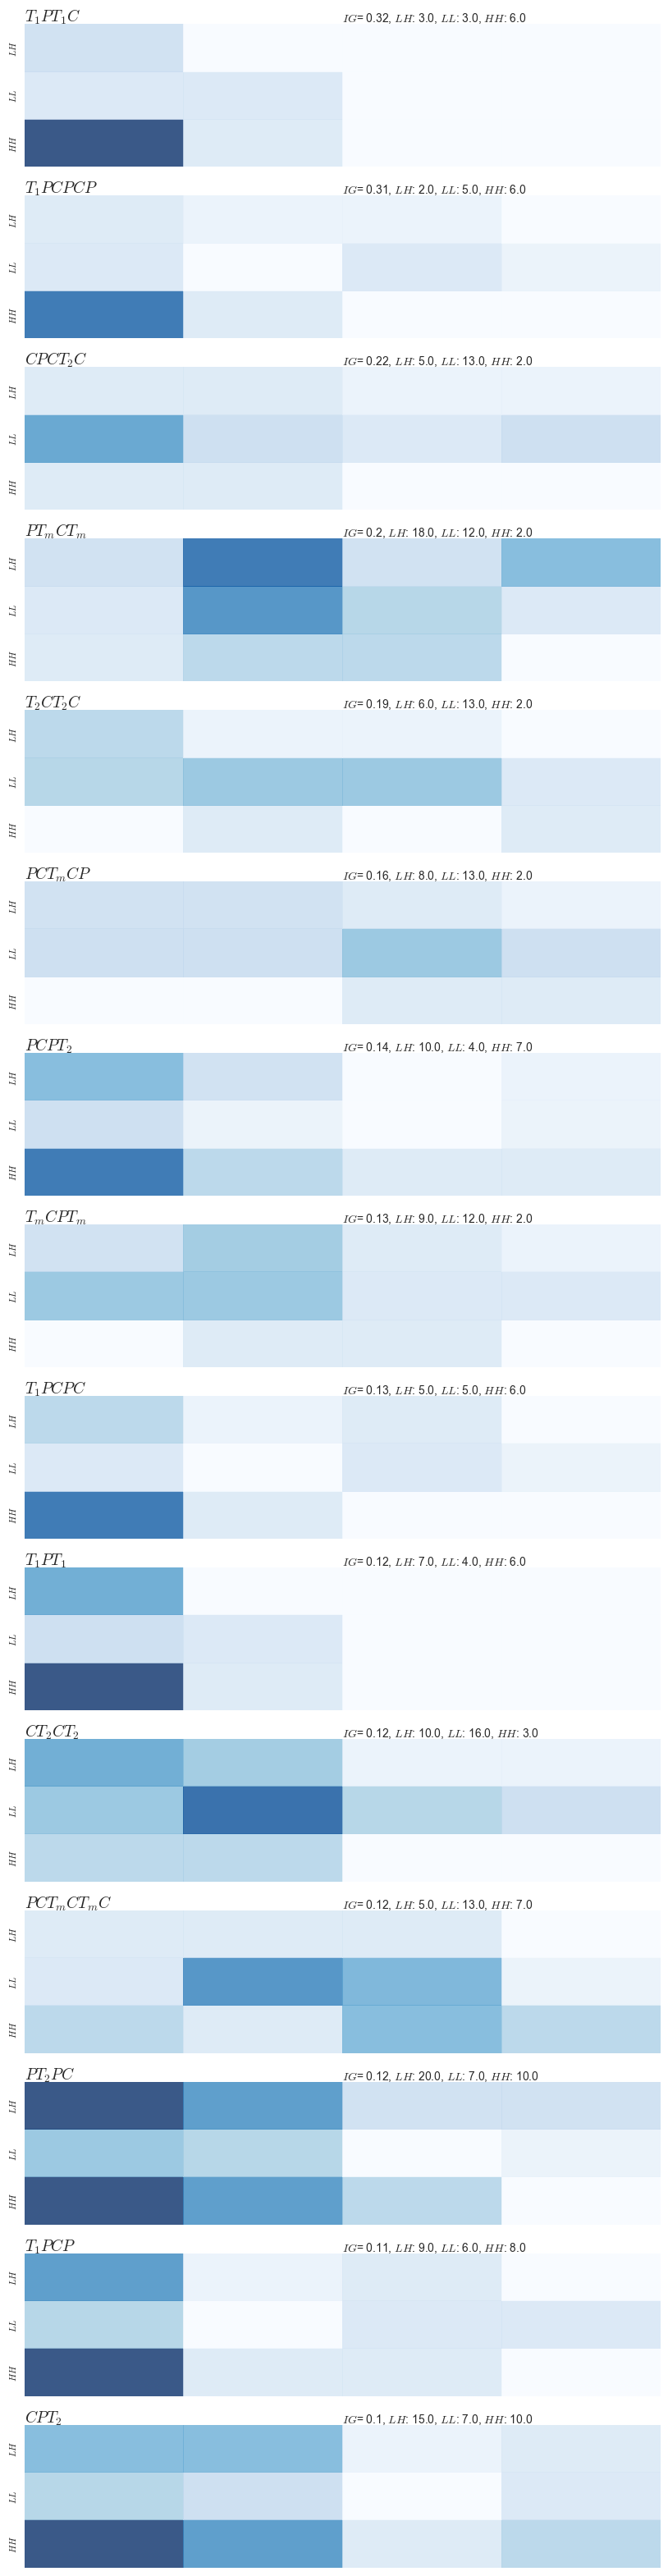

In [13]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops)[0]
fig, axes = plt.subplots(len(tops),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs])
for i,(seq,ig) in enumerate(tops):
    ax = axes[i]
    data = sequence_counts_both[seq]
    ax = axes[i]
    hl,ll,hh = np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,3.05, seq, fontsize=14)
    ax.text(2.0,3.05, "$IG$= {0}, $LH$: {1}, $LL$: {2}, $HH$: {3}".format(str(round(ig,2)),hl,ll,hh), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=False) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,40)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$HH$','$LL$','$LH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1

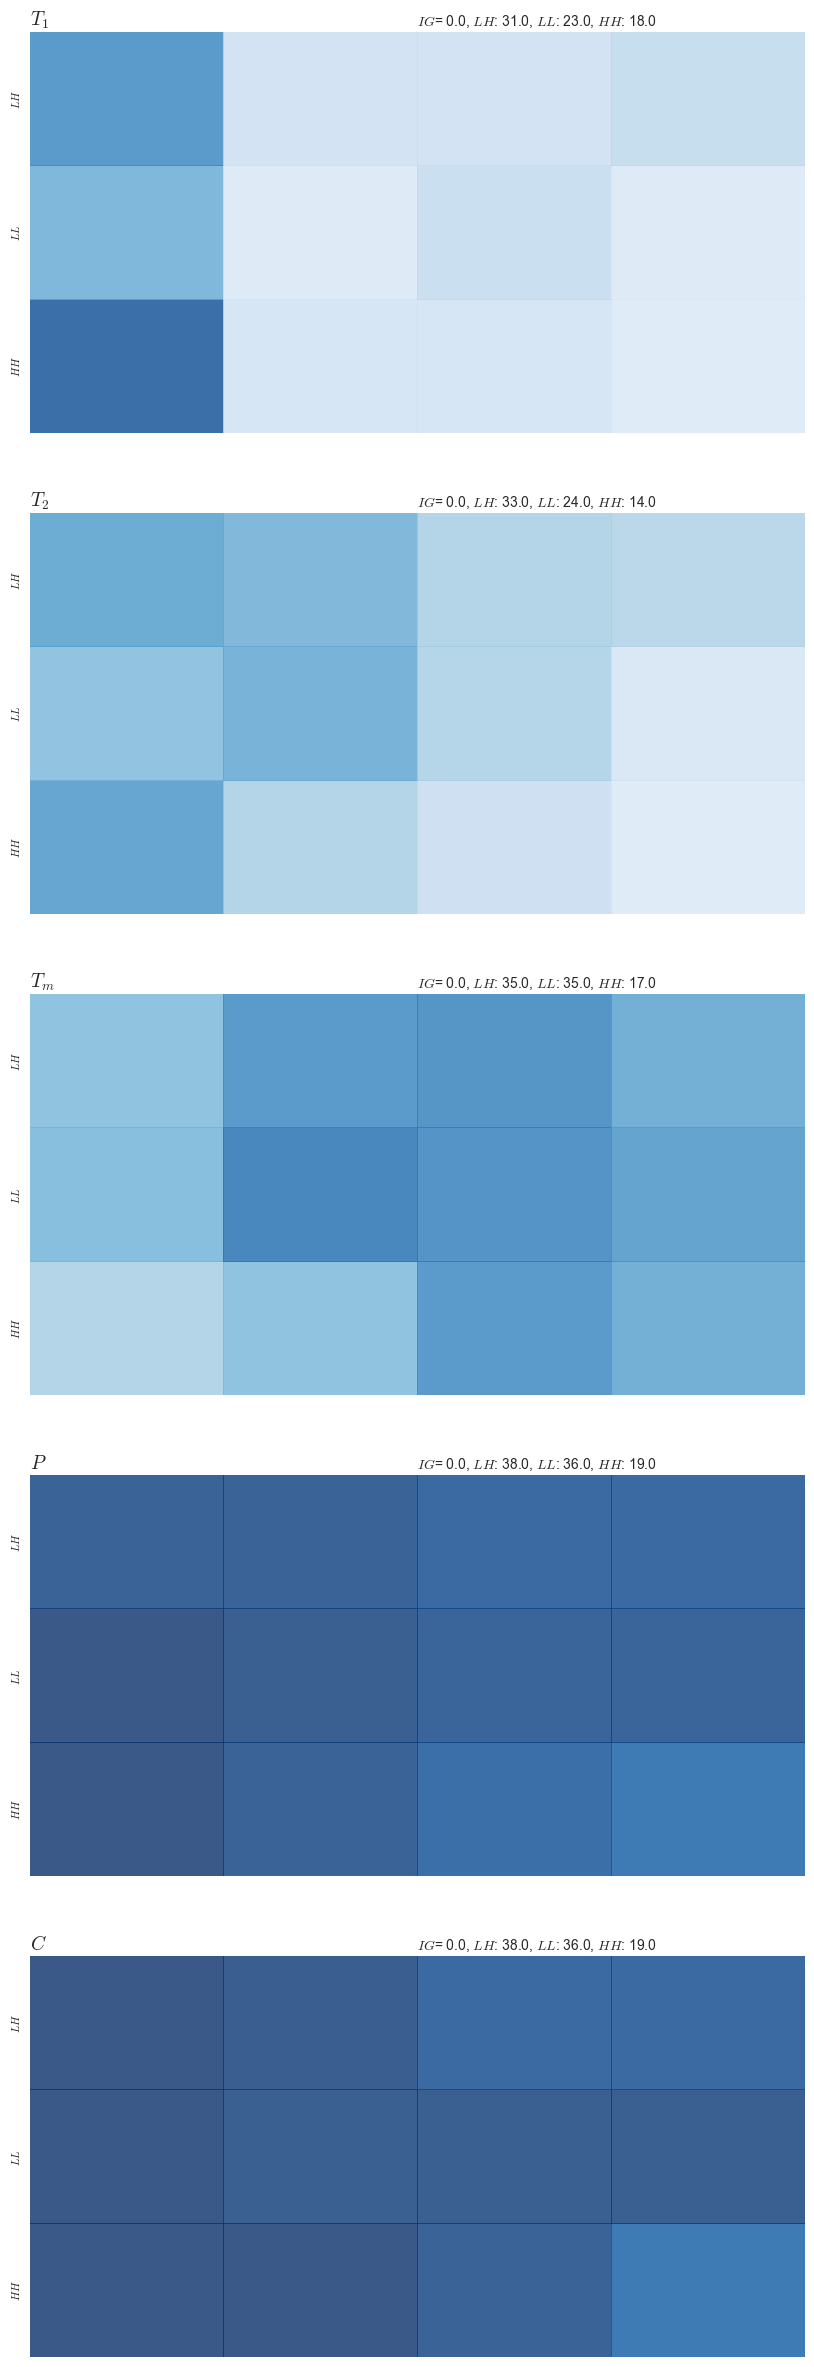

In [14]:
all_actions = [('Tb',0),('Ts',0),('Tc',0),('P',0),('C',0),]
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*all_actions)[0]
fig, axes = plt.subplots(len(all_actions),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs])

for i,(seq,ig) in enumerate(all_actions):
    ax = axes[i]
    data = sequence_counts_both[seq]
    ax = axes[i]
    hl,ll,h_ = np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,3.05, seq, fontsize=14)
    ax.text(2.0,3.05, "$IG$= {0}, $LH$: {1}, $LL$: {2}, $HH$: {3}".format(str(round(ig,2)),hl,ll,h_), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=False) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,30)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$HH$','$LL$','$LH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1

### Let's analyze the building block $T_1P$

In [26]:
print sequence_counts_both['TbP']*group_sizes[:,None]

[[ 15.   4.   5.   4.]
 [ 15.   3.   5.   2.]
 [ 14.   3.   2.   1.]]


In [74]:
seq = 'PCPTs'
arr = sequence_counts_group[seq]*group_sizes[:,None]
print arr
print sequence_counts_group[seq]
# print group_sizes
# print sequence_counts_both[seq]*group_sizes[:,None]

lh = arr[0]
ll = arr[1]
hh = arr[2]

table = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
print table
chi2, p, dof, ex = stats.chi2_contingency(table, correction=False)
print 'Chi^2 = {}, p = {}, dof = {}'.format(chi2, p, dof)

[[ 10.]
 [  4.]
 [  7.]]
[[ 0.26]
 [ 0.11]
 [ 0.37]]
[[array([ 10.]), array([ 28.])], [array([ 4.]), array([ 32.])], [array([ 7.]), array([ 12.])]]
Chi^2 = 5.22277917015, p = 0.0734324322214, dof = 2


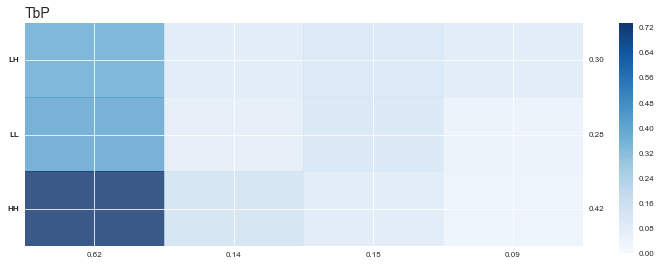

In [15]:
plot = plot_heat_map(sequence_counts_both['TbP'],'TbP',('LH','LL','HH'))

In [16]:
blocks_LH, time_coords_LH =  get_blocks_withTime_new(df,get_students('three groups','LH'),"Family",start=False,ignore=['I'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,get_students('three groups','LL'),"Family",start=False,ignore=['I'], as_list=True)
blocks_HH, time_coords_HH =  get_blocks_withTime_new(df,get_students('three groups','HH'),"Family",start=False,ignore=['I'], as_list=True)

In [17]:
def get_frequencies(seq_of_interest,blocks1,blocks2,blocks3,normalize_by='length'):
    def coo(seq, seq_of_interest):
        return float(occurrences(''.join(seq),seq_of_interest))
    
    if normalize_by == None:
        # count number of occurrences of "seq_of_interest" in a student's seq
        freq1 = {student : coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()}
    elif normalize_by == 'length':
        len_seqi = len(''.join([c for c in seq_of_interest if c.isupper()]))
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the length of seq
        freq1 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks2.iteritems()}
        freq3 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks3.iteritems()}
    else:
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the number of occurrences of the seq "normalize_by"
        freq1 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks2.iteritems()}
        freq3 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks3.iteritems()}
    return freq1.values(),freq2.values(),freq3.values()

def occurrences(string, sub):
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count
        
def make_hist_continuous(seq_of_interest,freq_HL,freq_LL,freq_HH):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    bins = np.arange(0,1.05,0.05)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.hist(freq_HH,color = 'g',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue) and HH (green)".format(seq_of_interest))
    return plt

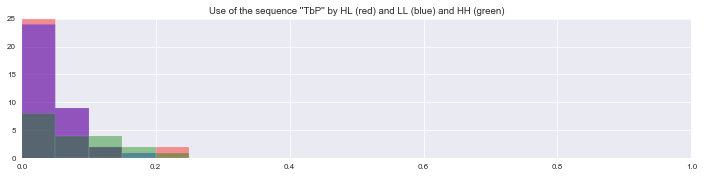

In [18]:
seq = 'TbP'
freq_LH,freq_LL,freq_HH = get_frequencies(seq,blocks_LH,blocks_LL,blocks_HH,normalize_by='length')
plot = make_hist_continuous(seq,freq_LH,freq_LL,freq_HH)
# plot.show()
# perform_comparative_stats(seq,freq_HL,freq_LL)
# freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='P')
# plot = make_hist_continuous(seq,freq_HL,freq_LL)
# plot.show()
# perform_comparative_stats(seq,freq_HL,freq_LL)

In [19]:
chi2, p, dof, ex = stats.chi2_contingency(sequence_counts_both['TbP']*group_sizes[:,None], correction=False)
print 'Chi^2 = {}, p = {}, dof = {}'.format(chi2, p, dof)

Chi^2 = 2.48804947434, p = 0.869802714937, dof = 6
